In [1]:
import argparse
import logging
import os
import sys
import time
import matplotlib.pyplot as plt
from IPython import display
import matplotlib.pyplot as plt
import numpy as np

from ai_economist.foundation import landmarks, resources

import ray
from rllib.utils import remote, saving
from utils import plotting
import rllib.tf_models
import rllib.fcnet
import yaml
from rllib.env_wrapper import RLlibEnvWrapper
from ray.rllib.agents.ppo import PPOTrainer
from ray.tune.logger import NoopLogger, pretty_print

Inside covid19_components.py: 1 GPUs are available.
Inside covid19_env.py: 1 GPUs are available.


/home/akash/miniconda3/envs/ai_economist/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/akash/miniconda3/envs/ai_economist/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/akash/miniconda3/envs/ai_economist/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/akash/miniconda3/envs/

In [2]:
def plot_map(maps, locs, ax=None, cmap_order=None):
    world_size = np.array(maps.get("Wood")).shape
    max_health = {"Wood": 1, "Stone": 1, "House": 1}
    n_agents = len(locs)

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10, 10))
    else:
        ax.cla()
    tmp = np.zeros((3, world_size[0], world_size[1]))
    cmap = plt.get_cmap("jet", n_agents)

    if cmap_order is None:
        cmap_order = list(range(n_agents))
    else:
        cmap_order = list(cmap_order)
        assert len(cmap_order) == n_agents

    scenario_entities = [k for k in maps.keys() if "source" not in k.lower()]
    for entity in scenario_entities:
        if entity == "House":
            continue
        elif resources.has(entity):
            if resources.get(entity).collectible:
                map_ = (
                    resources.get(entity).color[:, None, None]
                    * np.array(maps.get(entity))[None]
                )
                map_ /= max_health[entity]
                tmp += map_
        elif landmarks.has(entity):
            map_ = (
                landmarks.get(entity).color[:, None, None]
                * np.array(maps.get(entity))[None]
            )
            tmp += map_
        else:
            continue

    if isinstance(maps, dict):
        house_idx = np.array(maps.get("House")["owner"])
        house_health = np.array(maps.get("House")["health"])
    else:
        house_idx = maps.get("House", owner=True)
        house_health = maps.get("House")
    for i in range(n_agents):
        houses = house_health * (house_idx == cmap_order[i])
        agent = np.zeros_like(houses)
        agent += houses
        col = np.array(cmap(i)[:3])
        map_ = col[:, None, None] * agent[None]
        tmp += map_

    tmp *= 0.7
    tmp += 0.3

    tmp = np.transpose(tmp, [1, 2, 0])
    tmp = np.minimum(tmp, 1.0)

    ax.imshow(tmp, vmax=1.0, aspect="auto")

    bbox = ax.get_window_extent()

    for i in range(n_agents):
        r, c = locs[cmap_order[i]]
        col = np.array(cmap(i)[:3])
        ax.plot(c, r, "o", markersize=bbox.height * 20 / 550, color="w")
        ax.plot(c, r, "*", markersize=bbox.height * 15 / 550, color=col)

    ax.set_xticks([])
    ax.set_yticks([])


def plot_env_state(env, ax=None, remap_key=None):
    maps = env.world.maps
    locs = [agent.loc for agent in env.world.agents]

    if remap_key is None:
        cmap_order = None
    else:
        assert isinstance(remap_key, str)
        cmap_order = np.argsort(
            [agent.state[remap_key] for agent in env.world.agents]
        ).tolist()

    plot_map(maps, locs, ax, cmap_order)


def plot_log_state(dense_log, t, ax=None, remap_key=None):
    maps = dense_log["world"][t]
    states = dense_log["states"][t]

    n_agents = len(states) - 1
    locs = []
    for i in range(n_agents):
        r, c = states[str(i)]["loc"]
        locs.append([r, c])

    if remap_key is None:
        cmap_order = None
    else:
        assert isinstance(remap_key, str)
        key_val = np.array(
            [dense_log["states"][0][str(i)][remap_key] for i in range(n_agents)]
        )
        cmap_order = np.argsort(key_val).tolist()

    plot_map(maps, locs, ax, cmap_order)


def _format_logs_and_eps(dense_logs, eps):
    if isinstance(dense_logs, dict):
        return [dense_logs], [0]
    else:
        assert isinstance(dense_logs, (list, tuple))

    if isinstance(eps, (list, tuple)):
        return dense_logs, list(eps)
    elif isinstance(eps, (int, float)):
        return dense_logs, [int(eps)]
    elif eps is None:
        return dense_logs, list(range(np.minimum(len(dense_logs), 16)))
    else:
        raise NotImplementedError


def vis_world_array(dense_logs, ts, eps=None, axes=None, remap_key=None):
    dense_logs, eps = _format_logs_and_eps(dense_logs, eps)
    if isinstance(ts, (int, float)):
        ts = [ts]

    if axes is None:
        fig, axes = plt.subplots(
            len(eps),
            len(ts),
            figsize=(np.minimum(3.2 * len(ts), 16), 3 * len(eps)),
            squeeze=False,
        )

    else:
        fig = None

        if len(ts) == 1 and len(eps) == 1:
            axes = np.array([[axes]]).reshape(1, 1)
        else:
            try:
                axes = np.array(axes).reshape(len(eps), len(ts))
            except ValueError:
                print("Could not reshape provided axes array into the necessary shape!")
                raise

    for ti, t in enumerate(ts):
        for ei, ep in enumerate(eps):
            plot_log_state(dense_logs[ep], t, ax=axes[ei, ti], remap_key=remap_key)

    for ax, t in zip(axes[0], ts):
        ax.set_title("T = {}".format(t))
    for ax, ep in zip(axes[:, 0], eps):
        ax.set_ylabel("Episode {}".format(ep))

    return fig


def vis_world_range(
    dense_logs, t0=0, tN=None, N=5, eps=None, axes=None, remap_key=None
):
    dense_logs, eps = _format_logs_and_eps(dense_logs, eps)

    viable_ts = np.array([i for i, w in enumerate(dense_logs[0]["world"]) if w])
    if tN is None:
        tN = viable_ts[-1]
    assert 0 <= t0 < tN
    target_ts = np.linspace(t0, tN, N).astype(np.int)

    ts = set()
    for tt in target_ts:
        closest = np.argmin(np.abs(tt - viable_ts))
        ts.add(viable_ts[closest])
    ts = sorted(list(ts))
    if axes is not None:
        axes = axes[: len(ts)]
    return vis_world_array(dense_logs, ts, axes=axes, eps=eps, remap_key=remap_key)


def vis_builds(dense_logs, eps=None, ax=None):
    dense_logs, eps = _format_logs_and_eps(dense_logs, eps)

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(16, 3))
    cmap = plt.get_cmap("jet", len(eps))
    for i, ep in enumerate(eps):
        ax.plot(
            np.cumsum([len(b["builds"]) for b in dense_logs[ep]["Build"]]),
            color=cmap(i),
            label="Ep {}".format(ep),
        )
    ax.legend()
    ax.grid(b=True)
    ax.set_ylim(bottom=0)


def trade_str(c_trades, resource, agent, income=True):
    if income:
        p = [x["income"] for x in c_trades[resource] if x["seller"] == agent]
    else:
        p = [x["cost"] for x in c_trades[resource] if x["buyer"] == agent]
    if len(p) > 0:
        return "{:6.2f} (n={:3d})".format(np.mean(p), len(p))
    else:
        tmp = "~" * 8
        tmp = (" ") * 3 + tmp + (" ") * 3
        return tmp


def full_trade_str(c_trades, resource, a_indices, income=True):
    s_head = "{} ({})".format("Income" if income else "Cost", resource)
    ac_strings = [trade_str(c_trades, resource, buyer, income) for buyer in a_indices]
    s_tail = " | ".join(ac_strings)
    return "{:<15}: {}".format(s_head, s_tail)


def build_str(all_builds, agent):
    p = [x["income"] for x in all_builds if x["builder"] == agent]
    if len(p) > 0:
        return "{:6.2f} (n={:3d})".format(np.mean(p), len(p))
    else:
        tmp = "~" * 8
        tmp = (" ") * 3 + tmp + (" ") * 3
        return tmp


def full_build_str(all_builds, a_indices):
    s_head = "Income (Build)"
    ac_strings = [build_str(all_builds, builder) for builder in a_indices]
    s_tail = " | ".join(ac_strings)
    return "{:<15}: {}".format(s_head, s_tail)


def header_str(n_agents):
    s_head = ("_" * 15) + ":_"
    s_tail = "_|_".join([" Agent {:2d} ____".format(i) for i in range(n_agents)])
    return s_head + s_tail


def report(c_trades, all_builds, n_agents, a_indices=None):
    if a_indices is None:
        a_indices = list(range(n_agents))
    print(header_str(n_agents))
    resources = ["Wood", "Stone"]
    if c_trades is not None:
        for resource in resources:
            print(full_trade_str(c_trades, resource, a_indices, income=False))
        print("")
        for resource in resources:
            print(full_trade_str(c_trades, resource, a_indices, income=True))
    print(full_build_str(all_builds, a_indices))


def breakdown(log, remap_key=None):
    fig0 = vis_world_range(log, remap_key=remap_key)

    n = len(list(log["states"][0].keys())) - 1
    trading_active = "Trade" in log

    if remap_key is None:
        aidx = list(range(n))
    else:
        assert isinstance(remap_key, str)
        key_vals = np.array([log["states"][0][str(i)][remap_key] for i in range(n)])
        aidx = np.argsort(key_vals).tolist()

    all_builds = []
    for t, builds in enumerate(log["Build"]):
        if isinstance(builds, dict):
            builds_ = builds["builds"]
        else:
            builds_ = builds
        for build in builds_:
            this_build = {"t": t}
            this_build.update(build)
            all_builds.append(this_build)

    if trading_active:
        c_trades = {"Stone": [], "Wood": []}
        for t, trades in enumerate(log["Trade"]):
            if isinstance(trades, dict):
                trades_ = trades["trades"]
            else:
                trades_ = trades
            for trade in trades_:
                this_trade = {
                    "t": t,
                    "t_ask": t - trade["ask_lifetime"],
                    "t_bid": t - trade["bid_lifetime"],
                }
                this_trade.update(trade)
                c_trades[trade["commodity"]].append(this_trade)

        incomes = {
            "Sell Stone": [
                sum([t["income"] for t in c_trades["Stone"] if t["seller"] == aidx[i]])
                for i in range(n)
            ],
            "Buy Stone": [
                sum([-t["price"] for t in c_trades["Stone"] if t["buyer"] == aidx[i]])
                for i in range(n)
            ],
            "Sell Wood": [
                sum([t["income"] for t in c_trades["Wood"] if t["seller"] == aidx[i]])
                for i in range(n)
            ],
            "Buy Wood": [
                sum([-t["price"] for t in c_trades["Wood"] if t["buyer"] == aidx[i]])
                for i in range(n)
            ],
            "Build": [
                sum([b["income"] for b in all_builds if b["builder"] == aidx[i]])
                for i in range(n)
            ],
        }

    else:
        c_trades = None
        incomes = {
            "Build": [
                sum([b["income"] for b in all_builds if b["builder"] == aidx[i]])
                for i in range(n)
            ],
        }

    incomes["Total"] = np.stack([v for v in incomes.values()]).sum(axis=0)

    endows = [
        int(
            log["states"][-1][str(aidx[i])]["inventory"]["Coin"]
            + log["states"][-1][str(aidx[i])]["escrow"]["Coin"]
        )
        for i in range(n)
    ]

    n_small = np.minimum(4, n)

    report(c_trades, all_builds, n, aidx)

    cmap = plt.get_cmap("jet", n)
    rs = ["Wood", "Stone", "Coin"]

    fig1, axes = plt.subplots(1, len(rs) + 1, figsize=(16, 4), sharey=False)
    for r, ax in zip(rs, axes):
        for i in range(n):
            ax.plot(
                [
                    x[str(aidx[i])]["inventory"][r] + x[str(aidx[i])]["escrow"][r]
                    for x in log["states"]
                ],
                label=i,
                color=cmap(i),
            )
        ax.set_title(r)
        ax.legend()
        ax.grid(b=True)

    ax = axes[-1]
    for i in range(n):
        ax.plot(
            [x[str(aidx[i])]["endogenous"]["Labor"] for x in log["states"]],
            label=i,
            color=cmap(i),
        )
    ax.set_title("Labor")
    ax.legend()
    ax.grid(b=True)
    
    fig3, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=False)

    houses = [0] * n
    hs = [[] for _ in houses]

    for bs in dense_logs['Build']:
        for b in bs:
            houses[b['builder']] += 1

        for h, house in zip(hs, houses):
            h.append(house)
         
    ax = axes[0]
    for i in range(n):
        ax.plot(
            hs[i],
            label=i,
            color=cmap(i),
        )
        
    ax.set_title("House")
    ax.legend()
    ax.grid(b=True)

    productivity = list(map(lambda x: x['social/productivity'], log["scenario_metrics"]))
    equality = list(map(lambda x: x['social/equality'], log["scenario_metrics"]))
    welfare = list(map(lambda x: x['social_welfare/coin_eq_times_productivity'], log["scenario_metrics"]))

    ts = {'Productivity': productivity, 'Equality': equality, 'Social welfare': welfare}

    for i, ((k, v), ax) in enumerate(zip(ts.items(), axes[1:])):
        ax.plot(v, color=cmap(i))
        ax.set_title(k)
        ax.grid(True)

    tmp = np.array(log["world"][0]["Stone"])
    fig2, axes = plt.subplots(
        2 if trading_active else 1,
        n_small,
        figsize=(16, 8 if trading_active else 4),
        sharex="row",
        sharey="row",
        squeeze=False,
    )
    for i, ax in enumerate(axes[0]):
        rows = np.array([x[str(aidx[i])]["loc"][0] for x in log["states"]]) * -1
        cols = np.array([x[str(aidx[i])]["loc"][1] for x in log["states"]])
        ax.plot(cols[::20], rows[::20])
        ax.plot(cols[0], rows[0], "r*", markersize=15)
        ax.plot(cols[-1], rows[-1], "g*", markersize=15)
        ax.set_title("Agent {}".format(i))
        ax.set_xlim([-1, 1 + tmp.shape[1]])
        ax.set_ylim([-(1 + tmp.shape[0]), 1])
        
    global some, what

    if trading_active:
        for i, ax in enumerate(axes[1]):
            for r in ["Wood", "Stone"]:
                tmp = [
                    (s["t"], s["income"]) for s in c_trades[r] if s["seller"] == aidx[i]
                ]
                if tmp:
                    ts, prices = [np.array(x) for x in zip(*tmp)]
                    ax.plot(
                        np.stack([ts, ts]),
                        np.stack([np.zeros_like(prices), prices]),
                        color=resources.get(r).color,
                    )
                    ax.plot(
                        ts, prices, ".", color=resources.get(r).color, markersize=12
                    )

                tmp = [
                    (s["t"], -s["cost"]) for s in c_trades[r] if s["buyer"] == aidx[i]
                ]
                
                if tmp:
                    ts, prices = [np.array(x) for x in zip(*tmp)]
                    some, what = ts, prices
                    ax.plot(
                        np.stack([ts, ts]),
                        np.stack([np.zeros_like(prices), prices]),
                        color=resources.get(r).color,
                    )
                    ax.plot(
                        ts, prices, ".", color=resources.get(r).color, markersize=12
                    )
            ax.plot([-20, len(log["states"]) + 19], [0, 0], "w-")
            # ax.set_ylim([-10.2, 10.2]);
            ax.set_xlim([-20, len(log["states"]) + 19])
            ax.grid(b=True)
            ax.set_facecolor([0.3, 0.3, 0.3])
            
    return (fig0, fig1, fig2, fig3), incomes, endows, c_trades, all_builds


def plot_for_each_n(y_fun, n, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(5, 5))
    cmap = plt.get_cmap("jet", n)
    for i in range(n):
        ax.plot(y_fun(i), color=cmap(i), label=i)
    ax.legend()
    ax.grid(b=True)

In [3]:
def load_config(config_dir):
    config_path = os.path.join(config_dir, "custom.yaml")
    with open(config_path, "r") as f:
        run_configuration = yaml.safe_load(f)

    return config_dir, run_configuration

def build_trainer(run_configuration):
    """Finalize the trainer config by combining the sub-configs."""
    trainer_config = run_configuration.get("trainer")

    # === Env ===
    env_config = {
        "env_config_dict": run_configuration.get("env"),
        "num_envs_per_worker": trainer_config.get("num_envs_per_worker"),
    }

    # === Seed ===
    if trainer_config["seed"] is None:
        try:
            start_seed = int(run_configuration["metadata"]["launch_time"])
        except KeyError:
            start_seed = int(time.time())
    else:
        start_seed = int(trainer_config["seed"])

    final_seed = int(start_seed % (2 ** 16)) * 1000
    logger.info("seed (final): %s", final_seed)

    # === Multiagent Policies ===
    dummy_env = RLlibEnvWrapper(env_config)

    # Policy tuples for agent/planner policy types
    agent_policy_tuple = (
        None,
        dummy_env.observation_space,
        dummy_env.action_space,
        run_configuration.get("agent_policy"),
    )
    planner_policy_tuple = (
        None,
        dummy_env.observation_space_pl,
        dummy_env.action_space_pl,
        run_configuration.get("planner_policy"),
    )

    policies = {"a": agent_policy_tuple, "p": planner_policy_tuple}

    def policy_mapping_fun(i):
        if str(i).isdigit() or i == "a":
            return "a"
        return "p"

    # Which policies to train
    if run_configuration["general"]["train_planner"]:
        policies_to_train = ["a", "p"]
    else:
        policies_to_train = ["a"]

    # === Finalize and create ===
    trainer_config.update(
        {
            "env_config": env_config,
            "seed": final_seed,
            "multiagent": {
                "policies": policies,
                "policies_to_train": policies_to_train,
                "policy_mapping_fn": policy_mapping_fun,
            },
            "metrics_smoothing_episodes": trainer_config.get("num_workers")
            * trainer_config.get("num_envs_per_worker"),
        }
    )

    def logger_creator(config):
        return NoopLogger({}, "/tmp")

    ppo_trainer = PPOTrainer(
        env=RLlibEnvWrapper, config=trainer_config, logger_creator=logger_creator
    )

    return ppo_trainer

In [4]:
ray.init(log_to_driver=False)

logging.basicConfig(stream=sys.stdout, format="%(asctime)s %(message)s")
logger = logging.getLogger("main")
logger.setLevel(logging.DEBUG)

run_dir, run_config = load_config('/home/akash/GitHub/ai-economist/tutorials')

# Create a trainer object
trainer = build_trainer(run_config)

2023-05-24 11:24:08,994	INFO resource_spec.py:212 -- Starting Ray with 7.37 GiB memory available for workers and up to 3.7 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2023-05-24 11:24:09,299	INFO services.py:1148 -- View the Ray dashboard at localhost:8265
2023-05-24 11:24:09,866 seed (final): 42625000
2023-05-24 11:24:09,892	INFO trainer.py:428 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2023-05-24 11:24:09,893	INFO trainer.py:585 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2023-05-24 11:24:28,162	INFO trainable.py:180 -- _setup took 18.269 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-05-24 11:24:28,163	INFO trainable.py:217 -- Getting current IP.


In [5]:
logger.info("Not restoring trainer...")
# === Trainer-specific counters ===
training_step_last_ckpt = 0
epis_last_ckpt = 0

# For new runs, load only tf checkpoint weights
starting_weights_path_agents = run_config["general"].get(
    "restore_tf_weights_agents", ""
)
if starting_weights_path_agents:
    logger.info("Restoring agents TF weights...")
    saving.load_tf_model_weights(trainer, starting_weights_path_agents)
else:
    logger.info("Starting with fresh agent TF weights.")

starting_weights_path_planner = run_config["general"].get(
    "restore_tf_weights_planner", ""
)
if starting_weights_path_planner:
    logger.info("Restoring planner TF weights...")
    saving.load_tf_model_weights(trainer, starting_weights_path_planner)
else:
    logger.info("Starting with fresh planner TF weights.")

2023-05-24 11:24:28,205 Not restoring trainer...
2023-05-24 11:24:28,207 Restoring agents TF weights...
2023-05-24 11:24:28,539 loaded tf model weights:
	./rllib/phase1/ckpts/agent.tf.weights.global-step-25040000

2023-05-24 11:24:28,540 Restoring planner TF weights...
2023-05-24 11:24:28,773 loaded tf model weights:
	./rllib/phase1/ckpts/planner.tf.weights.global-step-25040000



In [6]:
env_obj = trainer.workers.local_worker().env

In [9]:
def do_plot(env, ax, fig):
    """Plots world state during episode sampling."""
    plotting.plot_env_state(env, ax)
    ax.set_aspect('equal')
    display.display(fig)
    display.clear_output(wait=True)

def play_episode(plot_every=100, do_dense_logging=False):
    global actions
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    # Set initial states
    scenario_metrics = []
    agent_states = {}
    for agent_idx in range(env_obj.env.n_agents):
        agent_states[str(agent_idx)] = trainer.get_policy("a").get_initial_state()
    planner_states = trainer.get_policy("p").get_initial_state()   

    # Play out the episode
    obs = env_obj.reset(force_dense_logging=True)
    for t in range(env_obj.env.episode_length):
        actions = {}
        for agent_idx in range(env_obj.env.n_agents):
            # Use the trainer object directly to sample actions for each agent
            actions[str(agent_idx)], agent_states[str(agent_idx)], _ = trainer.compute_action(
                obs[str(agent_idx)],
                agent_states[str(agent_idx)],
                policy_id="a",
                full_fetch=False
            )

        # Action sampling for the planner
        actions["p"] = trainer.compute_action(
            obs['p'], 
            planner_states, 
            policy_id='p',
            full_fetch=False
        )

        obs, rew, done, info = env_obj.step(actions)  
        scenario_metrics.append(env_obj.env.scenario_metrics())
        if done['__all__']:
            break
            
        if ((t+1) % plot_every) == 0:
            do_plot(env_obj.env, ax, fig)

    if ((t+1) % plot_every) != 0:
        do_plot(env_obj.env, ax, fig)
        
    env_obj.env.dense_log['scenario_metrics'] = scenario_metrics
    return env_obj.env.dense_log

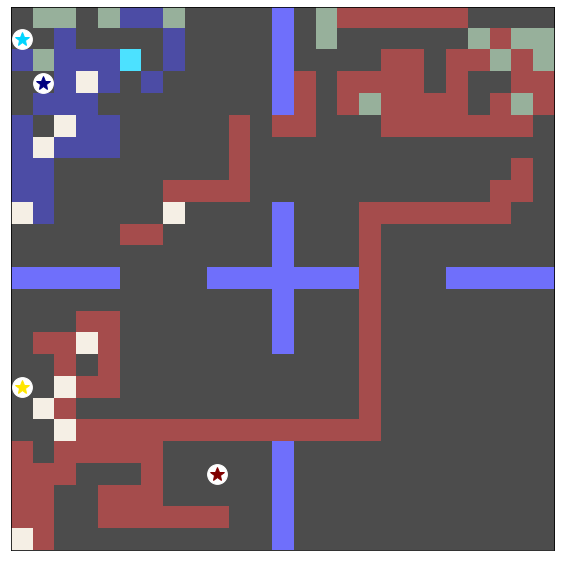

In [10]:
obs = env_obj.env.reset()
dense_logs = play_episode(plot_every=100)

/home/akash/miniconda3/envs/ai_economist/lib/python3.7/site-packages/ipykernel_launcher.py:173: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


_______________:_ Agent  0 _____|_ Agent  1 _____|_ Agent  2 _____|_ Agent  3 ____
Cost (Wood)    :   2.67 (n=  3) |    ~~~~~~~~    |    ~~~~~~~~    |   2.99 (n=113)
Cost (Stone)   :   3.00 (n= 12) |   3.00 (n=  1) |   2.50 (n=  2) |   3.10 (n= 98)

Income (Wood)  :   3.00 (n= 42) |   2.97 (n= 74) |    ~~~~~~~~    |    ~~~~~~~~   
Income (Stone) :   2.97 (n= 30) |   3.00 (n=  9) |   3.14 (n= 73) |   3.00 (n=  1)
Income (Build) :  16.47 (n= 27) |  11.33 (n=  2) |    ~~~~~~~~    |  22.25 (n=128)


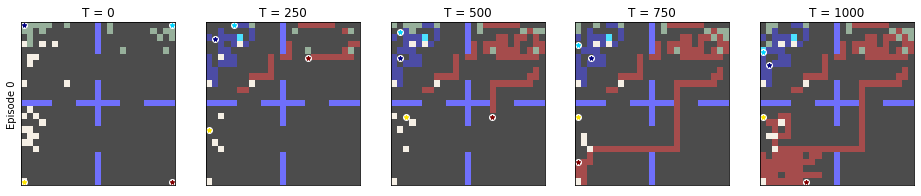

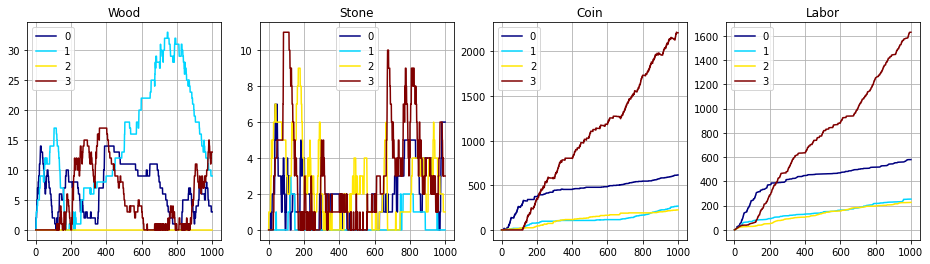

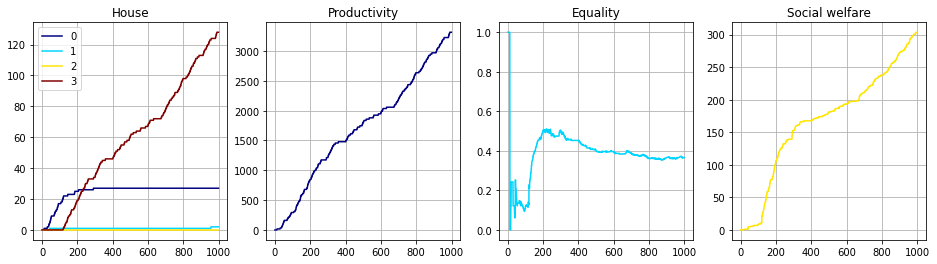

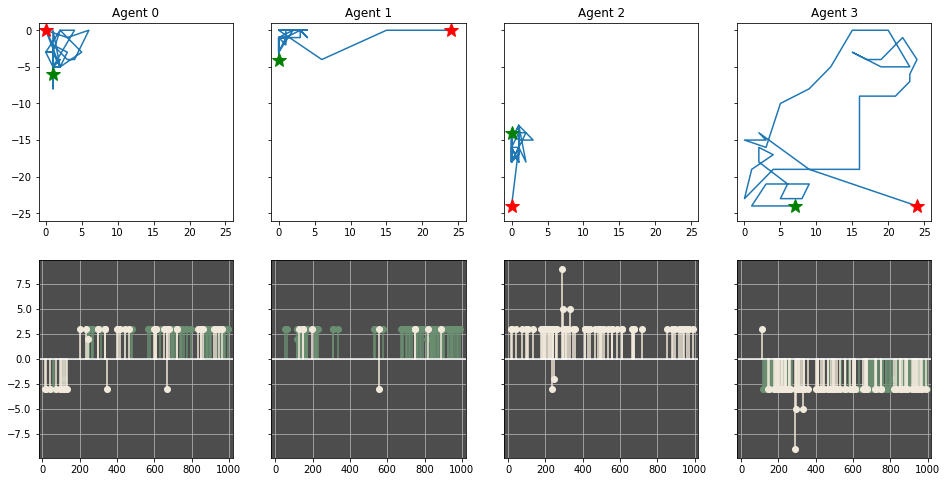

In [11]:
_ = breakdown(dense_logs)

In [21]:
[env_obj.env.world.agents[i].state['type'] for i in range(4)]

[16.472372947006132,
 11.331640623590097,
 13.267112338979295,
 22.249614304395735]

In [12]:
x = sorted(env_obj.env.world.agents, key=lambda x: x.state['build_skill'])
[(x[i].state['build_skill'], x[i].state['build_payment']) for i in range(4)]

[(0.11391710331709559, 13.267112338979295),
 (0.3619481561020035, 16.472372947006132),
 (0.3949931226438046, 11.331640623590097),
 (0.5462958764998518, 22.249614304395735)]

In [13]:
woods = []
for gs in dense_logs['Gather']:
    wood = [0] * 4
    for g in gs:
        wood[g['agent']] += g['n'] * (g['resource'] == 'Wood')
    woods.append(wood)
stones = []
for gs in dense_logs['Gather']:
    stone = [0] * 4
    for g in gs:
        stone[g['agent']] += g['n'] * (g['resource'] == 'Stone')
    stones.append(stone)
print('Woods:', np.array(woods).sum(axis=0))
print('Stones:', np.array(stones).sum(axis=0))
print('Total:', np.array(woods).sum(axis=0) + np.array(stones).sum(axis=0))

Woods: [69 85  0 28]
Stones: [51 10 72 34]
Total: [120  95  72  62]


In [14]:
rews = list(map(np.cumsum, zip(*map(lambda x: x.values(), dense_logs['rewards']))))

In [15]:
labor = list(zip(*map(lambda x: [v['endogenous']['Labor'] for k, v in x.items() if k != 'p'], dense_logs['states'])))

In [16]:
coins = list(zip(*map(lambda x: [v['inventory']['Coin']+v['escrow']['Coin'] for k, v in x.items() if k != 'p'], dense_logs['states'])))

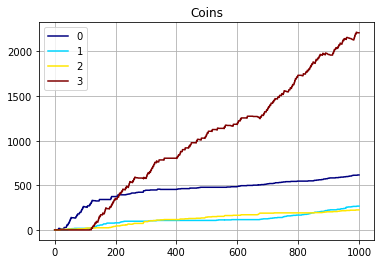

In [17]:
cmap = plt.get_cmap("jet", len(rews)-1)
for i, r in enumerate(coins):
#     if i == 0: continue
    plt.plot(r, c=cmap(i), label=i)
plt.grid(True)
plt.title('Coins')
plt.legend()

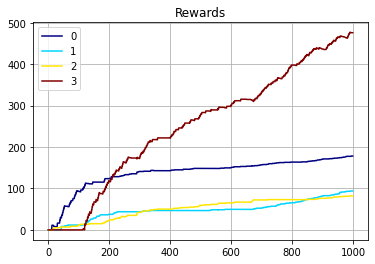

In [18]:
cmap = plt.get_cmap("jet", len(rews)-1)
for i, r in enumerate(rews[:-1]):
#     if i == 0: continue
    plt.plot(r, c=cmap(i), label=i)
plt.grid(True)
plt.title('Rewards')
plt.legend()

In [19]:
dense_logs.keys()

dict_keys(['world', 'states', 'actions', 'rewards', 'Build', 'Trade', 'Gather', 'scenario_metrics'])

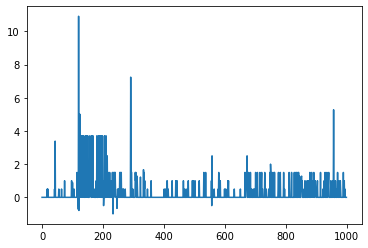

In [20]:
plt.plot([x["p"] for x in dense_logs['rewards']])

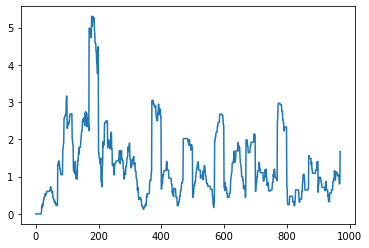

In [57]:
window = 30
plt.plot(np.convolve([x["p"] for x in dense_logs['rewards']], np.ones(window), 'valid') / window)

In [58]:
periodic_income = np.diff(np.array(list(zip(*map(lambda x: [v['inventory']['Coin']+v['escrow']['Coin'] for k, v in x.items() if k != 'p'], dense_logs['states'][0::100])))), axis=1).T
tax_paid = np.array([[x[str(i)]['tax_paid'] for i in range(4)] for x in filter(lambda x: not not x, dense_logs['PeriodicTax'])])
ubi = np.array([[x[str(i)]['lump_sum'] for i in range(4)] for x in filter(lambda x: not not x, dense_logs['PeriodicTax'])])

[  0.      9.7    39.475  84.2   160.725 204.1   510.3  ]


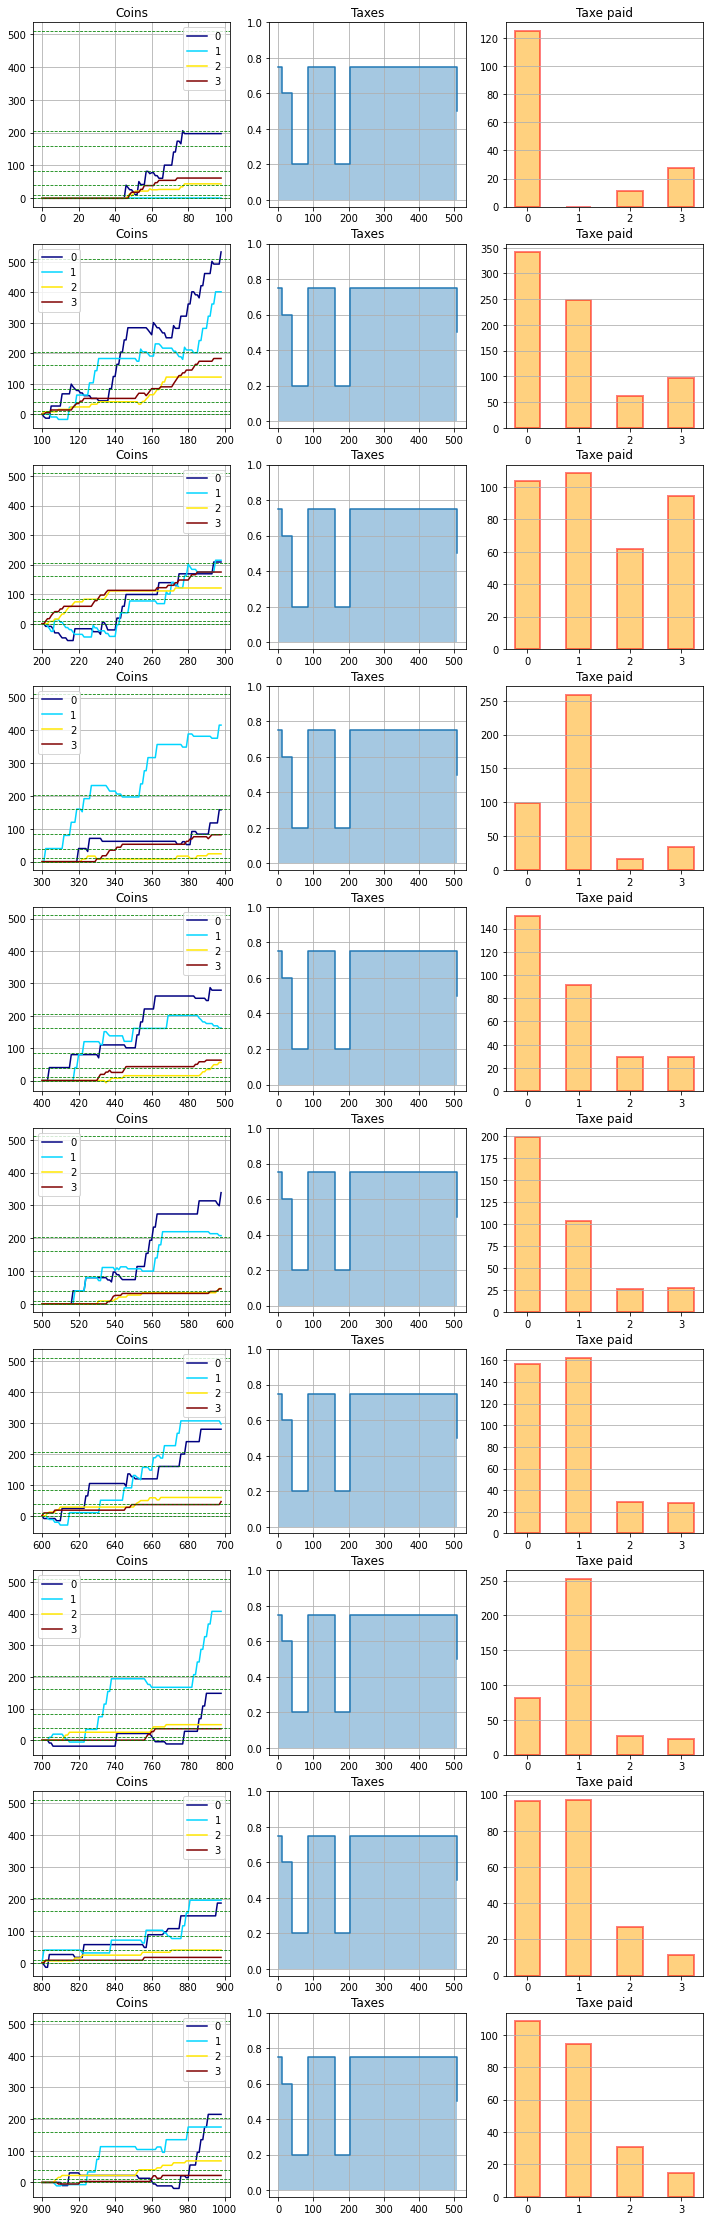

In [59]:
x = env_obj.env.components[-1].bracket_cutoffs
print(x)
fig, axes = plt.subplots(10, 3, figsize=(4*3, 4*10))
prev_coins = np.array([0, 0, 0, 0])
for i, [ax1, ax2, ax3] in enumerate(axes):
    coins = np.array(list(zip(*map(lambda x: [v['inventory']['Coin']+v['escrow']['Coin'] for k, v in x.items() if k != 'p'], dense_logs['states'][i*100+1:(i+1)*100]))))
    coins = coins - coins[:, 0].reshape(-1, 1)
    taxes = list(filter(lambda x: not not x, dense_logs['PeriodicTax']))[i]['schedule']
    
    cmap = plt.get_cmap("jet", 4)
    for j, r in enumerate(coins):
        ax1.plot(np.arange(i*100, (i+1)*100-1), r, c=cmap(j), label=j)
    ax1.grid(True)
    for j in x:
        ax1.axhline(y=j, color='green', linestyle='--', lw=0.8)
    ax1.set_title('Coins')
    ax1.legend()
    
    ax2.fill_between(x, taxes, step='post', alpha=0.4)
    ax2.step(x, taxes, where='post')
    ax2.set_title('Taxes')
    ax2.set_yticks(np.linspace(0, 1, 6))
    ax2.grid(True)
    
    ax3.bar(np.arange(4), tax_paid[i], color ='orange',
            width = 0.5, ec='red', alpha=0.5, lw=2)
    ax3.set_title('Taxe paid')
    plt.xticks(np.arange(4))
    ax3.grid(True, axis='y')

In [24]:
np.array(list(zip(*map(lambda x: [v['inventory']['Coin']+v['escrow']['Coin'] for k, v in x.items() if k != 'p'], dense_logs['states'][99::100]))))[0]

array([ 28.26711234, 155.42781324, 296.05531324, 328.05343824,
       451.31093824, 531.35843824, 612.09281324, 696.75906324,
       791.54843824, 852.19218824])

In [25]:
np.array(list(zip(*map(lambda x: [v['inventory']['Coin']+v['escrow']['Coin'] for k, v in x.items() if k != 'p'], dense_logs['states'][0::100]))))[0][:-1]

array([  0.        ,  57.42781324, 189.05531324, 288.05343824,
       380.31093824, 495.35843824, 583.09281324, 660.75906324,
       747.54843824, 826.19218824])

In [26]:
np.array(list(zip(*map(lambda x: [v['inventory']['Coin']+v['escrow']['Coin'] for k, v in x.items() if k != 'p'], dense_logs['states'][99::100])))) - np.array(list(zip(*map(lambda x: [v['inventory']['Coin']+v['escrow']['Coin'] for k, v in x.items() if k != 'p'], dense_logs['states'][0::100]))))[:,:-1]

array([[ 28.26711234,  98.        , 107.        ,  40.        ,
         71.        ,  36.        ,  29.        ,  36.        ,
         44.        ,  26.        ],
       [476.        , 242.        ,  68.        , 390.        ,
        284.        , 166.        , 351.        , 209.        ,
        112.        , 208.        ],
       [  0.        , 389.        , 320.        , 263.        ,
        345.        , 299.        , 171.        , 355.        ,
        323.        ,  49.        ],
       [ 40.33164062, 111.        ,  25.        ,  67.        ,
        100.        ,  59.        ,   9.        ,  40.        ,
         41.        ,  37.        ]])

In [27]:
periodic_income

array([[ 57.42781324, 425.31531324,  40.42781324,  61.42781324],
       [131.6275    , 216.7725    , 355.7725    , 135.8275    ],
       [ 98.998125  ,  84.758125  , 260.343125  ,  75.900625  ],
       [ 92.2575    , 345.8425    , 218.8425    , 103.0575    ],
       [115.0475    , 250.2325    , 311.2325    , 123.4875    ],
       [ 87.734375  , 125.496875  , 250.876875  ,  95.891875  ],
       [ 77.66625   , 293.50875   , 153.50875   ,  75.31625   ],
       [ 86.789375  , 159.931875  , 305.931875  ,  87.346875  ],
       [ 78.64375   , 100.28375   , 263.62875   ,  77.44375   ],
       [ 59.285625  , 133.028125  ,  65.043125  ,  62.643125  ]])

In [28]:
np.array(list(zip(*map(lambda x: [v['inventory']['Coin']+v['escrow']['Coin'] for k, v in x.items() if k != 'p'], dense_logs['states']))))[0][400]

380.3109382406423

In [29]:
periodic_income

array([[ 57.42781324, 425.31531324,  40.42781324,  61.42781324],
       [131.6275    , 216.7725    , 355.7725    , 135.8275    ],
       [ 98.998125  ,  84.758125  , 260.343125  ,  75.900625  ],
       [ 92.2575    , 345.8425    , 218.8425    , 103.0575    ],
       [115.0475    , 250.2325    , 311.2325    , 123.4875    ],
       [ 87.734375  , 125.496875  , 250.876875  ,  95.891875  ],
       [ 77.66625   , 293.50875   , 153.50875   ,  75.31625   ],
       [ 86.789375  , 159.931875  , 305.931875  ,  87.346875  ],
       [ 78.64375   , 100.28375   , 263.62875   ,  77.44375   ],
       [ 59.285625  , 133.028125  ,  65.043125  ,  62.643125  ]])

In [30]:
periodic_income.mean(axis=0)

array([ 88.54778132, 213.51703132, 222.56078132,  89.83428132])

In [31]:
periodic_income.mean()

153.61496882406422

In [32]:
tax_paid.astype(int)

array([[ 11, 131,   0,  19],
       [ 68, 127, 127,  85],
       [ 75,  42, 127,  24],
       [ 30, 127, 127,  47],
       [ 49, 127, 127,  70],
       [ 27, 119, 127,  42],
       [ 21, 127, 127,   3],
       [ 27, 127, 127,  30],
       [ 33,  79, 127,  31],
       [ 13, 127,  36,  32]])

In [33]:
print('Net amount received', (ubi - tax_paid).mean(axis=0))

Net amount received [ 37.62107009 -40.28296868 -32.03921868  34.70111726]


In [42]:
(ubi - tax_paid).mean(axis=0)[[0,3]].mean()

36.16109367593577

In [40]:
env_obj.env.scenario_metrics()

{'social/productivity': 6456.260877151826,
 'social/equality': 0.5196175777458727,
 'social_welfare/coin_eq_times_productivity': 838.6966595702688,
 'social_welfare/inv_income_weighted_coin_endow': 940.4312541933429,
 'social_welfare/inv_income_weighted_utility': 234.43630242285542,
 'endow/0/Coin': 2166.0,
 'endow/0/Stone': 12.0,
 'endow/0/Wood': 3.0,
 'endogenous/0/Labor': 1212.0,
 'util/0': 469.7436313673738,
 'endow/1/Coin': 692.6026740338757,
 'endow/1/Stone': 3.0,
 'endow/1/Wood': 10.0,
 'endogenous/1/Labor': 549.5,
 'util/1': 194.11626778746702,
 'endow/2/Coin': 3104.0,
 'endow/2/Stone': 2.0,
 'endow/2/Wood': 2.0,
 'endogenous/2/Labor': 1479.0,
 'util/2': 621.0832308565991,
 'endow/3/Coin': 493.65820311795045,
 'endow/3/Stone': 5.0,
 'endow/3/Wood': 0.0,
 'endogenous/3/Labor': 574.0,
 'util/3': 148.0532000498358,
 'endow/p/Coin': 0,
 'endow/p/Stone': 0,
 'endow/p/Wood': 0,
 'util/p': 838.6966595702688,
 'labor/weighted_cost': 0.008052546834350466,
 'labor/warmup_integrator': 391

In [11]:
env_obj.env.world.agents[0].action

{'Build': 0,
 'ContinuousDoubleAuction.Buy_Stone': 0,
 'ContinuousDoubleAuction.Sell_Stone': 0,
 'ContinuousDoubleAuction.Buy_Wood': 0,
 'ContinuousDoubleAuction.Sell_Wood': 0,
 'Gather': 0}

In [12]:
env_obj.env.world.agents[0].single_action_map

{1: ['Build', 1],
 2: ['ContinuousDoubleAuction.Buy_Stone', 1],
 3: ['ContinuousDoubleAuction.Buy_Stone', 2],
 4: ['ContinuousDoubleAuction.Buy_Stone', 3],
 5: ['ContinuousDoubleAuction.Buy_Stone', 4],
 6: ['ContinuousDoubleAuction.Buy_Stone', 5],
 7: ['ContinuousDoubleAuction.Buy_Stone', 6],
 8: ['ContinuousDoubleAuction.Buy_Stone', 7],
 9: ['ContinuousDoubleAuction.Buy_Stone', 8],
 10: ['ContinuousDoubleAuction.Buy_Stone', 9],
 11: ['ContinuousDoubleAuction.Buy_Stone', 10],
 12: ['ContinuousDoubleAuction.Buy_Stone', 11],
 13: ['ContinuousDoubleAuction.Sell_Stone', 1],
 14: ['ContinuousDoubleAuction.Sell_Stone', 2],
 15: ['ContinuousDoubleAuction.Sell_Stone', 3],
 16: ['ContinuousDoubleAuction.Sell_Stone', 4],
 17: ['ContinuousDoubleAuction.Sell_Stone', 5],
 18: ['ContinuousDoubleAuction.Sell_Stone', 6],
 19: ['ContinuousDoubleAuction.Sell_Stone', 7],
 20: ['ContinuousDoubleAuction.Sell_Stone', 8],
 21: ['ContinuousDoubleAuction.Sell_Stone', 9],
 22: ['ContinuousDoubleAuction.Sell_Sto

In [13]:
dense_logs.keys()

dict_keys(['world', 'states', 'actions', 'rewards', 'Build', 'Trade', 'Gather', 'PeriodicTax'])

In [25]:
dr = np.arange(
0,1+0.05, 0.05
            )
dr[dr <= 1]

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [26]:
len(dr)

21

In [29]:
env_obj.env.world.planner.action

{'PeriodicBracketTax.TaxIndexBracket_000': 0,
 'PeriodicBracketTax.TaxIndexBracket_009': 0,
 'PeriodicBracketTax.TaxIndexBracket_039': 0,
 'PeriodicBracketTax.TaxIndexBracket_084': 0,
 'PeriodicBracketTax.TaxIndexBracket_160': 0,
 'PeriodicBracketTax.TaxIndexBracket_204': 0,
 'PeriodicBracketTax.TaxIndexBracket_510': 0}

In [27]:
env_obj.env.world.planner.action_dim

{'PeriodicBracketTax.TaxIndexBracket_000': 22,
 'PeriodicBracketTax.TaxIndexBracket_009': 22,
 'PeriodicBracketTax.TaxIndexBracket_039': 22,
 'PeriodicBracketTax.TaxIndexBracket_084': 22,
 'PeriodicBracketTax.TaxIndexBracket_160': 22,
 'PeriodicBracketTax.TaxIndexBracket_204': 22,
 'PeriodicBracketTax.TaxIndexBracket_510': 22}

In [28]:
env_obj.env.world.agents[0].action_dim

{'Build': 1,
 'ContinuousDoubleAuction.Buy_Stone': 11,
 'ContinuousDoubleAuction.Sell_Stone': 11,
 'ContinuousDoubleAuction.Buy_Wood': 11,
 'ContinuousDoubleAuction.Sell_Wood': 11,
 'Gather': 4}

In [44]:
_ = env_obj.env.reset()

In [14]:
[env_obj.env.world.agents[i].state['build_skill'] for i in range(4)]

[3.0, 0.001, 0.1518079417266478, 0.1721806210797443]

In [15]:
[env_obj.env.world.agents[i].state['build_payment'] for i in range(4)]

[40.0, 1.0, 13.267112338979295, 16.472372947006132]

In [16]:
env_obj.env.world.agents[0].state['type']

'AI'

In [31]:
planner_rews = list(map(lambda x: x['p'], dense_logs['rewards']))

In [24]:
dense_logs.keys()

dict_keys(['world', 'states', 'actions', 'rewards', 'Build', 'Trade', 'Gather', 'PeriodicTax'])

In [70]:
dense_logs['actions'][900]

{'0': {'ContinuousDoubleAuction.Buy_Wood': 1},
 '1': {},
 '2': {},
 '3': {'ContinuousDoubleAuction.Sell_Stone': 11},
 'p': {'PeriodicBracketTax.TaxIndexBracket_000': 2,
  'PeriodicBracketTax.TaxIndexBracket_009': 3,
  'PeriodicBracketTax.TaxIndexBracket_039': 2,
  'PeriodicBracketTax.TaxIndexBracket_160': 3,
  'PeriodicBracketTax.TaxIndexBracket_204': 1,
  'PeriodicBracketTax.TaxIndexBracket_510': 3}}

In [59]:
env_obj.env.get_agent('p').action

{'PeriodicBracketTax.TaxIndexBracket_000': 0,
 'PeriodicBracketTax.TaxIndexBracket_009': 0,
 'PeriodicBracketTax.TaxIndexBracket_039': 0,
 'PeriodicBracketTax.TaxIndexBracket_084': 0,
 'PeriodicBracketTax.TaxIndexBracket_160': 0,
 'PeriodicBracketTax.TaxIndexBracket_204': 0,
 'PeriodicBracketTax.TaxIndexBracket_510': 0}

In [25]:
env_obj.env.scenario_metrics()

{'social/productivity': 5381.084999999999,
 'social/equality': 0.057153281664697464,
 'social_welfare/coin_eq_times_productivity': 76.88666666666963,
 'social_welfare/inv_income_weighted_coin_endow': 105.58805748259728,
 'social_welfare/inv_income_weighted_utility': -25.08405685574391,
 'endow/0/Coin': 5139.124999999999,
 'endow/0/Stone': 35.0,
 'endow/0/Wood': 25.0,
 'endogenous/0/Labor': 2165.25,
 'util/0': 479.1760727360579,
 'endow/1/Coin': 93.22500000000001,
 'endow/1/Stone': 0.0,
 'endow/1/Wood': 0.0,
 'endogenous/1/Labor': 490.75,
 'util/1': -61.69341490559155,
 'endow/2/Coin': 78.11000000000001,
 'endow/2/Stone': 1.0,
 'endow/2/Wood': 1.0,
 'endogenous/2/Labor': 277.0,
 'util/2': -22.23867131890109,
 'endow/3/Coin': 70.62499999999997,
 'endow/3/Stone': 0.0,
 'endow/3/Wood': 1.0,
 'endogenous/3/Labor': 190.5,
 'util/3': -6.8522684050719604,
 'endow/p/Coin': 0,
 'endow/p/Stone': 0,
 'endow/p/Wood': 0,
 'util/p': 76.88666666666963,
 'labor/weighted_cost': 0.21,
 'labor/warmup_inte

In [ ]:
dense_logs['PeriodicTax']

In [39]:
dense_logs['states'][0]

{'inventory': {'Coin': 0, 'Stone': 0, 'Wood': 0},
 'escrow': {'Coin': 0, 'Stone': 0, 'Wood': 0},
 'endogenous': {}}

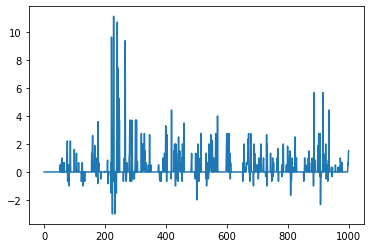

In [32]:
plt.plot(planner_rews)

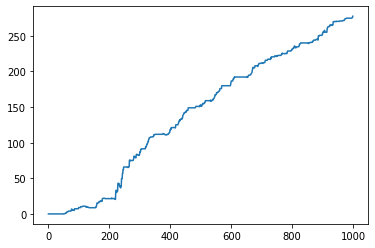

In [34]:
plt.plot(np.cumsum(planner_rews))

In [14]:
dense_logs['states'][0]

{'0': {'loc': [0, 24],
  'inventory': {'Coin': 0.0, 'Stone': 0, 'Wood': 0},
  'escrow': {'Coin': 0, 'Stone': 0, 'Wood': 0},
  'endogenous': {'Labor': 0},
  'build_payment': 11.331640623590097,
  'build_skill': 0.44778981015931585,
  'bonus_gather_prob': 0.09415288361427865},
 '1': {'loc': [24, 0],
  'inventory': {'Coin': 0.0, 'Stone': 0, 'Wood': 0},
  'escrow': {'Coin': 0, 'Stone': 0, 'Wood': 0},
  'endogenous': {'Labor': 0},
  'build_payment': 13.267112338979295,
  'build_skill': 0.24016402586070829,
  'bonus_gather_prob': 0.4175093544471118},
 '2': {'loc': [0, 0],
  'inventory': {'Coin': 0.0, 'Stone': 0, 'Wood': 0},
  'escrow': {'Coin': 0, 'Stone': 0, 'Wood': 0},
  'endogenous': {'Labor': 0},
  'build_payment': 16.472372947006132,
  'build_skill': 0.1127071377001283,
  'bonus_gather_prob': 0.23151670592770612},
 '3': {'loc': [24, 24],
  'inventory': {'Coin': 0.0, 'Stone': 0, 'Wood': 0},
  'escrow': {'Coin': 0, 'Stone': 0, 'Wood': 0},
  'endogenous': {'Labor': 0},
  'build_payment': 2

In [44]:
dense_logs['Gather'][0]

[{'agent': 3, 'resource': 'Wood', 'n': 2, 'loc': [0, 0]},
 {'agent': 1, 'resource': 'Stone', 'n': 2, 'loc': [24, 0]}]

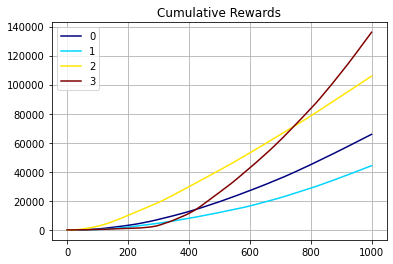

In [55]:
cmap = plt.get_cmap("jet", len(rews)-1)
for i, r in enumerate(rews[:-1]):
    r = np.cumsum(r)
    plt.plot(r, c=cmap(i), label=i)
plt.grid(True)
plt.title('Cumulative Rewards')
plt.legend()

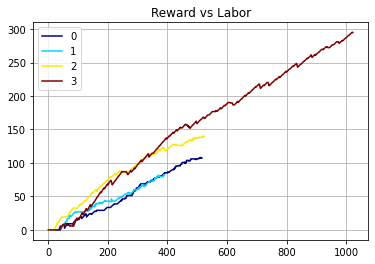

In [58]:
cmap = plt.get_cmap("jet", len(rews)-1)
for i, r in enumerate(rews[:-1]):
    plt.plot(labor[i][1:], r, c=cmap(i), label=i)
plt.grid(True)
plt.title('Reward vs Labor')
plt.legend()

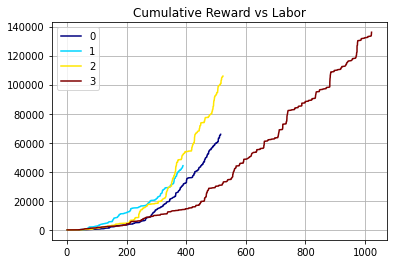

In [61]:
cmap = plt.get_cmap("jet", len(rews)-1)
for i, r in enumerate(rews[:-1]):
    r = np.cumsum(r)
    plt.plot(labor[i][1:], r, c=cmap(i), label=i)
plt.grid(True)
plt.title('Cumulative Reward vs Labor')
plt.legend()